In [ ]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
from pathlib import Path
import asyncio
import matplotlib.pyplot as plt
import hvplot.pandas
import hvplot
from IPython.display import Markdown

pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 2000)
pd.set_option("display.width", 1000)

## Algorithmic Trading Helper Functions

In [2]:
def fetch_data():
    """Fetches the latest prices."""
    print("Fetching data...")
    # Set the file path
    filepath = Path("../Resources/aapl.csv")

    # Read the CSV located at the file path into a Pandas DataFrame
    df = pd.read_csv(filepath, parse_dates=True, infer_datetime_format=True)

    return df

In [3]:
def generate_signals(df):
    """Generates trading signals for a given dataset."""
    print("-----> Generating trading signals <-----")
    # Set window
    short_window = 10
    long_window = 50

    signals = df.copy()
    signals["Signal"] = 0.0

    # Generate the short and long moving averages
    signals["SMA10"] = signals["close"].rolling(window=short_window).mean()
    signals["SMA50"] = signals["close"].rolling(window=long_window).mean()

    # Generate the trading signal 0 or 1,
    signals["Signal"][short_window:] = np.where(
        signals["SMA10"][short_window:] > signals["SMA50"][short_window:], 1.0, 0.0
    )

    # Calculate the points in time at which a position should be taken, 1 or -1
    signals["Entry/Exit"] = signals["Signal"].diff()
    print("-----> Trading signals generated  <-----")

    return signals

In [4]:
def plot_signals(signals_df):
    # Visualize exit position relative to close price
    exit = signals_df[signals_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
        color='red',
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize entry position relative to close price
    entry = signals_df[signals_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
        color='green',
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize close price for the investment
    security_close = signals_df[['close']].hvplot(
        line_color='lightgray',
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize moving averages
    moving_avgs = signals_df[['SMA10', 'SMA50']].hvplot(
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Overlay plots
    entry_exit_plot = security_close * moving_avgs * entry * exit
    entry_exit_plot.opts(xaxis=None)

In [5]:
def setup_backtest_strategy(signals_df, initial_capital, share_size):

    # Take the share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
    signals_df['Position'] = share_size * signals_df['Signal']

    # Find the points in time where a 500 share position is bought or sold
    signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

    # Multiply share price by entry/exit positions and get the cumulatively sum
    signals_df['Portfolio Holdings'] = signals_df['close'] * signals_df['Entry/Exit Position'].cumsum()

    # Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
    signals_df['Portfolio Cash'] = initial_capital - (signals_df['close'] * signals_df['Entry/Exit Position']).cumsum()

    # Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
    signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

    # Calculate the portfolio daily returns
    signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

    # Calculate the cumulative returns
    signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

    # Visualize exit position relative to total portfolio value
    exit = signals_df[signals_df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
        color='red',
        legend=False,
        ylabel='Total Portfolio Value',
        width=1000,
        height=400
    )

    # Visualize entry position relative to total portfolio value
    entry = signals_df[signals_df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
        color='green',
        legend=False,
        ylabel='Total Portfolio Value',
        width=1000,
        height=400
    )

    # Visualize total portoflio value for the investment
    total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
        line_color='lightgray',
        ylabel='Total Portfolio Value',
        width=1000,
        height=400
    )

    # Overlay plots
    portfolio_entry_exit_plot = total_portfolio_value * entry * exit
    portfolio_entry_exit_plot.opts(xaxis=None)
    
    return signals_df

In [6]:
def portfolio_evaluation_table(signals_df):
    
    # Prepare DataFrame for metrics
    metrics = [
        'Annual Return',
        'Cumulative Returns',
        'Annual Volatility',
        'Sharpe Ratio',
        'Sortino Ratio']

    columns = ['Backtest']

    # Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
    portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
    
    # Calculate cumulative return
    portfolio_evaluation_df.loc['Cumulative Returns'] = signals_df['Portfolio Cumulative Returns'].iloc[-1]

    # Calculate annualized return
    portfolio_evaluation_df.loc['Annual Return'] = (
        signals_df['Portfolio Daily Returns'].mean() * 252
    )

    # Calculate annual volatility
    portfolio_evaluation_df.loc['Annual Volatility'] = (
        signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
    )

    # Calculate Sharpe Ratio
    portfolio_evaluation_df.loc['Sharpe Ratio'] = (
        signals_df['Portfolio Daily Returns'].mean() * 252) / (
        signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
    )

    # Calculate Downside Return
    sortino_ratio_df = signals_df[['Portfolio Daily Returns']].copy()
    sortino_ratio_df.loc[:,'Downside Returns'] = 0

    target = 0
    mask = sortino_ratio_df['Portfolio Daily Returns'] < target
    sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
    portfolio_evaluation_df

    # Calculate Sortino Ratio
    down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
    expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
    sortino_ratio = expected_return/down_stdev

    portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
    portfolio_evaluation_df.head()
    
    return portfolio_evaluation_df

In [7]:
def build_plot(df, plt_title):
    """Build the plot."""

    plot = df.plot(title=plt_title)
    return

In [22]:
def initialize(cash=None):
    """Initialize the plot, data storage, and account balances."""
    print("Initializing Account and DataFrame")

    # Initialize Account
#     account = {"balance": [cash], "shares": [0]}
    account = {"balance": cash, "shares": 0}
    
    # Initialize DataFrame
    df = fetch_data()

    # Initialize the plot
    build_plot(df,"Corn Price")

    return account, df

In [18]:
# # async def execute_trade_strategy(signals, account):
# def execute_trade_strategy(signals_df, account):
    
#     """Makes a buy/sell/hold decision."""
    
#     # Initialize trade evaluation DataFrame with columns
#     trade_evaluation_df = pd.DataFrame(
#         columns=[
#             'Stock', 
#             'Entry Date', 
#             'Exit Date', 
#             'Shares', 
#             'Entry Share Price', 
#             'Exit Share Price', 
#             'Entry Portfolio Holding', 
#             'Exit Portfolio Holding', 
#             'Profit/Loss']
#     )

#     print("**Executing Trading Strategy**")

#     for index, row in signals_df.iterrows():
        
#         print(account)
        
#         if row['Entry/Exit'] == 1:
#             print("Buy")
#             entry_date = index
            
#             share_size = round(account["balance"][-1] / row["close"],0) * 0.001
#             new_balance = account["balance"][-1] - share_size * row["close"]
#             new_shares = account["shares"][-1] + share_size
#             account["balance"].append(new_balance)
#             account["shares"].append(new_shares)
            
# #             account["balance"]-= share_size * row["close"]
# #             account["shares"] += share_size 
            
#             entry_portfolio_holding = abs(row['Portfolio Holdings'])
#             entry_share_price = row['close']

#         elif row['Entry/Exit'] == -1:
#             print("Sell")
#             exit_date = index
#             new_balance = account["balance"][-1] + row["close"] * account["shares"][-1]
#             new_shares = 0
            
#             account["balance"].append(new_balance)
#             account["shares"].append(new_shares)
            
# #             account["balance"] += row["close"] * account["shares"]
# #             account["shares"] = 0
#             exit_portfolio_holding = abs(row['close'] * row['Entry/Exit Position'])
#             exit_share_price = row['close']
#             profit_loss =  entry_portfolio_holding - exit_portfolio_holding
#             trade_evaluation_df = trade_evaluation_df.append(
#                 {
#                     'Stock': 'AAPL',
#                     'Entry Date': entry_date,
#                     'Exit Date': exit_date,
#                     'Shares': share_size,
#                     'Entry Share Price': entry_share_price,
#                     'Exit Share Price': exit_share_price,
#                     'Entry Portfolio Holding': entry_portfolio_holding,
#                     'Exit Portfolio Holding': exit_portfolio_holding,
#                     'Profit/Loss': profit_loss
#                 },
#                 ignore_index=True)
            
# #         print(f"Account balance: ${account['balance'].iloc[-1]}")
# #         print(f"Account shares : {account['shares'].iloc[-1]}")
        
#         account_df = pd.DataFrame([account])
#         yield account_df
    
        
#     print("**Trading Strategy Executed**")

In [30]:
def execute_trade_strategy(signals_df, account):
    
    """Makes a buy/sell/hold decision."""
    
    # Initialize trade evaluation DataFrame with columns
    trade_evaluation_df = pd.DataFrame(
        columns=[
            'Stock', 
            'Entry Date', 
            'Exit Date', 
            'Shares', 
            'Entry Share Price', 
            'Exit Share Price', 
            'Entry Portfolio Holding', 
            'Exit Portfolio Holding', 
            'Profit/Loss']
    )

    print("**Executing Trading Strategy**")

    for index, row in signals_df.iterrows():
        
        if row['Entry/Exit'] == 1:
            print("Buy")
            entry_date = index
            
            share_size = round(account["balance"] / row["close"],0) * 0.001
            new_balance = account["balance"] - share_size * row["close"]
            new_shares = account["shares"] + share_size
            account["balance"]-= share_size * row["close"]
            account["shares"] += share_size 
            entry_portfolio_holding = abs(row['Portfolio Holdings'])
            entry_share_price = row['close']

        elif row['Entry/Exit'] == -1:
            
            print("Sell")
            exit_date = index
            new_balance = account["balance"] + row["close"] * account["shares"]
            new_shares = 0
            account["balance"] += row["close"] * account["shares"]
            account["shares"] = 0
            exit_portfolio_holding = abs(row['close'] * row['Entry/Exit Position'])
            exit_share_price = row['close']
            profit_loss =  entry_portfolio_holding - exit_portfolio_holding
            
            trade_evaluation_df = trade_evaluation_df.append(
                {
                    'Stock': 'AAPL',
                    'Entry Date': entry_date,
                    'Exit Date': exit_date,
                    'Shares': share_size,
                    'Entry Share Price': entry_share_price,
                    'Exit Share Price': exit_share_price,
                    'Entry Portfolio Holding': entry_portfolio_holding,
                    'Exit Portfolio Holding': exit_portfolio_holding,
                    'Profit/Loss': profit_loss
                },
                ignore_index=True)
            
        print(f"Account balance: ${account['balance']}")
        print(f"Account shares : {account['shares']}")
        
    print("**Trading Strategy Executed**")
    
    return trade_evaluation_df

In [24]:
def visualize_hvplot_tables(signals_df, trade_evaluation_df, portfolio_evaluation_df):
    
    # Create hvplot tables for both trade_evaluation_df and portfolio_evaluation_df
    portfolio_evaluation_table = portfolio_evaluation_df.hvplot.table()
    trade_evaluation_table = trade_evaluation_df.hvplot.table()
    
    price_df = signals_df[['close', 'SMA10', 'SMA50']]
    price_chart = price_df.hvplot.line()
    price_chart.opts(xaxis=None)
    
    # Assemble dashboard visualization
    display(Markdown("# Trading Dashboard"))
    display(price_chart)
    display(trade_evaluation_table + portfolio_evaluation_table)

## Data Extration and account initialization

Initializing Account and DataFrame
Fetching data...
-----> Generating trading signals <-----
-----> Trading signals generated  <-----


/Users/shuran/anaconda3/envs/develop/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


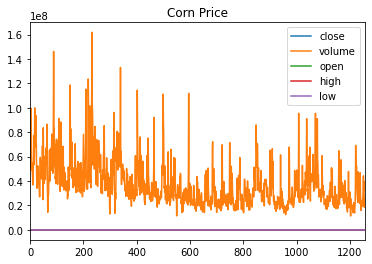

In [25]:
# Turns on the interactive mode of matplotlib (https://matplotlib.org/api/_as_gen/matplotlib.pyplot.ion.html)
plt.ion()
# Set the initial account configuration with $100000
initial_capital = 100000
share_size = 500
account, df = initialize(initial_capital)
# Generate signals for trading
signals_df = generate_signals(df)
# Plot signal dataframe
plot_signals(signals_df)

## Portfolio Performance Evaluation

In [26]:
signals_eval_df = setup_backtest_strategy(signals_df, initial_capital, share_size)
signals_eval_df.dropna(inplace=True)
portfolio_evaluation_df = portfolio_evaluation_table(signals_eval_df)

## Trading Execution

In [31]:
# Execute the trading strategy
# loop = asyncio.get_event_loop()
# account_df = pd.DataFrame([{"balance": initial_capital, "shares": 0}])
# for new_account_df in execute_trade_strategy(signals_df, account):
#     account_df = account_df.append(new_account_df, ignore_index=True)
#     print(account_df)
#     # Update the plot
#     account_df["shares"].plot()
# #     build_plot(account_df, "Account Info")
#     # Update line chart
#     plt.pause(1)
#     # Refresh the matplotlib plotting area to avoid extra memory consumption
#     plt.close()
#     await asyncio.sleep(1)

trade_evaluation_df = execute_trade_strategy(signals_df, account)

**Executing Trading Strategy**
Buy
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account balance: $99800.12341
Account shares : 1.737
Account bal

Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares : 0.862
Account balance: $99890.94923
Account shares :

Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.523
Account balance: $99905.44797000002
Account shares : 0.5

## Hvplot table visualization

In [32]:
visualize_hvplot_tables(signals_df, trade_evaluation_df, portfolio_evaluation_df)

# Trading Dashboard

:NdOverlay   [Variable]
   :Curve   [index]   (value)

:Layout
   .Table.I  :Table   [Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss]
   .Table.II :Table   [Backtest]